# LSTM for sequence classification

In [1]:
%matplotlib inline
import lstm_utils
import importlib
importlib.reload(lstm_utils)
from lstm_utils import *
import sgdr
importlib.reload(sgdr)
from sgdr import *

Using TensorFlow backend.


## Loading the IMDB dataset

We're going to look at the IMDB dataset, which contains movie reviews from IMDB, along with their sentiment. Keras comes with some helpers for this dataset.

In [2]:
from keras.datasets import imdb
# fix random seed for reproducibility
np.random.seed(3)
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)
# truncate and pad input sequences
max_review_length = 500

In [3]:
#X_train[0]

In [4]:
trn = sequence.pad_sequences(X_train, maxlen=max_review_length)
test = sequence.pad_sequences(X_test, maxlen=max_review_length)

In [5]:
idx = imdb.get_word_index()
idx_arr = sorted(idx, key=idx.get)
idx_arr[:10]

['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it', 'i']

...and this is the mapping from id to word

In [6]:
idx2word = {v: k for k, v in idx.items()}

# Defining the model

In [7]:
# getting pretrained word embeddings 
#The pickled files from fast.ai are not working. I pickled them again and worked
#glove_path = get_glove_dataset()

In [8]:
glove_path = "/data/yinterian/Glove/6B.50d"

This function creates an array of work embeddings for our IMDB datset. It is using Glove embedings. You can find more about Glove embeddings here:
https://nlp.stanford.edu/projects/glove/

In [9]:
emb = create_emb(top_words, glove_path, idx2word)

In [10]:
emb.shape

(5000, 50)

try recurrent_dropout=0.2

In [11]:
vocab_size = top_words
seq_len = max_review_length

inputs = Input(shape=(seq_len,), dtype='int32')
x = Embedding(vocab_size, 50, input_length=seq_len, mask_zero=True,
              weights=[emb], embeddings_regularizer=regularizers.l2(1e-5))(inputs)
x = Dropout(0.2)(x)
x = LSTM(100, implementation=2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [73]:
model.fit(trn, y_train, validation_data=(test, y_test), epochs=5, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 282s - loss: 0.6277 - acc: 0.7202 - val_loss: 0.4481 - val_acc: 0.8454
Epoch 2/5
25000/25000 [==============================] - 283s - loss: 0.4012 - acc: 0.8680 - val_loss: 0.4078 - val_acc: 0.8643
Epoch 3/5
25000/25000 [==============================] - 279s - loss: 0.3453 - acc: 0.8956 - val_loss: 0.4053 - val_acc: 0.8619
Epoch 4/5
25000/25000 [==============================] - 279s - loss: 0.3018 - acc: 0.9102 - val_loss: 0.3855 - val_acc: 0.8696
Epoch 5/5
25000/25000 [==============================] - 281s - loss: 0.2688 - acc: 0.9240 - val_loss: 0.3978 - val_acc: 0.8577


In [74]:
model.optimizer.lr.assign(0.0001)

<tf.Tensor 'Assign_79:0' shape=() dtype=float32_ref>

In [75]:
model.fit(trn, y_train, validation_data=(test, y_test), epochs=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 283s - loss: 0.2491 - acc: 0.9292 - val_loss: 0.3987 - val_acc: 0.8772
Epoch 2/2
25000/25000 [==============================] - 283s - loss: 0.2191 - acc: 0.9431 - val_loss: 0.4002 - val_acc: 0.8727


In [49]:
batch_size=64
steps_per_epoch = math.ceil(25000/batch_size)

In [101]:
# without pretrined embedings
vocab_size = top_words
seq_len = max_review_length

inputs = Input(shape=(seq_len,), dtype='int32')
x = Embedding(vocab_size, 20, input_length=seq_len, mask_zero=True,
              embeddings_regularizer=regularizers.l2(1e-4))(inputs)
x = Dropout(0.25)(x)
x = LSTM(100, implementation=2)(x)
x = Dense(1, activation='sigmoid')(x)
model2 = Model(inputs=inputs, outputs=x)
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [102]:
# found this with LR_Finder
model2.optimizer.lr.assign(0.01)

<tf.Tensor 'Assign_159:0' shape=() dtype=float32_ref>

In [103]:
model2.fit(trn, y_train, validation_data=(test, y_test), epochs=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 467s - loss: 0.5486 - acc: 0.7142 - val_loss: 0.3861 - val_acc: 0.8429
Epoch 2/2
25000/25000 [==============================] - 466s - loss: 0.3373 - acc: 0.8696 - val_loss: 0.3280 - val_acc: 0.8704


In [104]:
model2.optimizer.lr.assign(0.001)

<tf.Tensor 'Assign_178:0' shape=() dtype=float32_ref>

In [105]:
model2.fit(trn, y_train, validation_data=(test, y_test), epochs=2, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 464s - loss: 0.3181 - acc: 0.8810 - val_loss: 0.3461 - val_acc: 0.8672
Epoch 2/2
25000/25000 [==============================] - 467s - loss: 0.2924 - acc: 0.8935 - val_loss: 0.3524 - val_acc: 0.8641


## Learning Rate Finder

In [80]:
batch_size=64
steps_per_epoch = math.ceil(25000/batch_size)
cb = LR_Finder(steps_per_epoch, start_lr=1e-7, end_lr=10)
model2.fit(trn, y_train, epochs=1, validation_data=(test, y_test), batch_size=batch_size, 
           callbacks=[cb], verbose=1)

Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 285s - loss: 18.6379 - acc: 0.5463 - val_loss: 235.2400 - val_acc: 0.4986


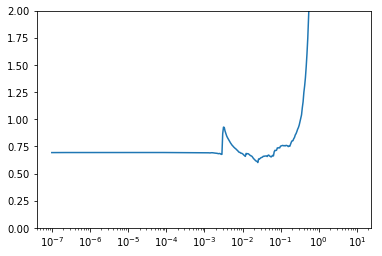

In [84]:
%matplotlib inline
plt.plot(cb.history['lr'], cb.losses)
plt.ylim((0,2))
plt.xscale('log');

## Cosine Annealing

In [12]:
vocab_size = top_words
seq_len = max_review_length

inputs = Input(shape=(seq_len,), dtype='int32')
x = Embedding(vocab_size, 50, input_length=seq_len, mask_zero=True,
              weights=[emb], embeddings_regularizer=regularizers.l2(1e-5))(inputs)
x = Dropout(0.2)(x)
x = LSTM(100, implementation=2)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
batch_size=64
steps_per_epoch = math.ceil(25000/batch_size)
def fc_cos(model, steps_per_epoch, nc,  cl, lr, tmult=1):
    for i in range(nc):
        cb = CosAnneal(steps_per_epoch, init_lr=lr)
        model.fit(trn, y_train, validation_data=(test, y_test), epochs=cl,
                         batch_size=64, callbacks=[cb])
        cl *= tmult

In [117]:
# LSTM is a different beast, It keeps overfitting after lr restarts. 
fc_cos(model, steps_per_epoch, nc=3, cl=5, lr=0.01)

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 463s - loss: 0.5282 - acc: 0.7648 - val_loss: 0.3989 - val_acc: 0.8488
Epoch 2/5
25000/25000 [==============================] - 465s - loss: 0.3745 - acc: 0.8672 - val_loss: 0.3577 - val_acc: 0.8766
Epoch 3/5
25000/25000 [==============================] - 464s - loss: 0.3230 - acc: 0.8972 - val_loss: 0.3537 - val_acc: 0.8830
Epoch 4/5
25000/25000 [==============================] - 467s - loss: 0.3076 - acc: 0.9092 - val_loss: 0.3609 - val_acc: 0.8847
Epoch 5/5
25000/25000 [==============================] - 466s - loss: 0.2872 - acc: 0.9198 - val_loss: 0.3692 - val_acc: 0.8890
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 463s - loss: 0.2638 - acc: 0.9317 - val_loss: 0.3779 - val_acc: 0.8863
Epoch 2/5
25000/25000 [==============================] - 464s - loss: 0.2418 - acc: 0.9397 - val_loss: 0.3866 - val_acc: 0.8865
Epoc

## Random parameter search

This model has many parameters. Here are some of them with their current defaul values
* top_words (5000)
* max_review_length (500)
* Dropout value (0.2)
* embeddings_regularizer (1e-5)
* number of units in the LSTM (100)
* size of the embeding (50)
* start with a pre-trained embeding (we can use it for certain sizes)
* optimization type (adam)
* learning rates

In [14]:
units_arr = np.array([16, 24, 64, 128, 256])
embeding_size_arr = np.array([16, 24, 64, 128])
emb_reg_arr = np.array([1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])
dropout_arr = np.array([0.0, 0.1, 0.2, 0.4])

In [15]:
import random 
K = 50
list_arr = [units_arr, embeding_size_arr, emb_reg_arr, dropout_arr]
list_names = ["units", "embeding_size", "emb_reg", "dropout"]
parm_list = {}
for l, name in zip(list_arr, list_names):
    parm_list[name] = random.choices(l, k = K)

In [135]:
i = 10
[u, emb, reg, d]  = [parm_list[name][i] for name in list_names]
print(u, emb, reg, d)
model = get_LSTM_model(units=u, embeding_size=emb, emb_reg=reg, dropout=d)

128 24 0.1 0.2


In [16]:
K = 20
for i in range(K):
    [u, emb, reg, d]  = [parm_list[name][i] for name in list_names]
    print(u, emb, reg, d)
    model = get_LSTM_model(units=u, embeding_size=emb, emb_reg=reg, dropout=d)
    fc_cos(model, steps_per_epoch, nc=1, cl=5, lr=0.01)

16 16 0.0001 0.0
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 373s - loss: 0.5449 - acc: 0.7540 - val_loss: 0.4557 - val_acc: 0.8271
Epoch 2/5
25000/25000 [==============================] - 372s - loss: 0.6700 - acc: 0.6638 - val_loss: 0.7265 - val_acc: 0.5821
Epoch 3/5
25000/25000 [==============================] - 371s - loss: 0.5224 - acc: 0.7854 - val_loss: 0.4221 - val_acc: 0.8597
Epoch 4/5
25000/25000 [==============================] - 372s - loss: 0.3895 - acc: 0.8788 - val_loss: 0.3791 - val_acc: 0.8772
Epoch 5/5
25000/25000 [==============================] - 372s - loss: 0.3427 - acc: 0.8965 - val_loss: 0.3594 - val_acc: 0.8838
23 64 0.001 0.4
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 394s - loss: 0.7028 - acc: 0.6976 - val_loss: 0.5695 - val_acc: 0.7938
Epoch 2/5
25000/25000 [==============================] - 386s - loss: 0.7095 - acc: 0.7778 - val_lo

25000/25000 [==============================] - 409s - loss: 0.4944 - acc: 0.8123 - val_loss: 0.4067 - val_acc: 0.8642
Epoch 4/5
25000/25000 [==============================] - 410s - loss: 0.4525 - acc: 0.8431 - val_loss: 0.3975 - val_acc: 0.8710
Epoch 5/5
25000/25000 [==============================] - 410s - loss: 0.3759 - acc: 0.8885 - val_loss: 0.3766 - val_acc: 0.8850
64 128 0.01 0.1
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 419s - loss: 0.8437 - acc: 0.6155 - val_loss: 0.6550 - val_acc: 0.6622
Epoch 2/5
25000/25000 [==============================] - 419s - loss: 0.8565 - acc: 0.6586 - val_loss: 0.8046 - val_acc: 0.5966
Epoch 3/5
22656/25000 [==========================>...] - ETA: 26s - loss: 0.9469 - acc: 0.6640

KeyboardInterrupt: 

In [24]:

units_arr = np.array([20, 30, 40, 50, 60, 70])
embeding_size_arr = np.array([20, 30, 40, 50, 60, 70])
emb_reg_arr = np.array([1e-2, 1e-3, 1e-4, 1e-5])
dropout_arr = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5])

K = 20
list_arr = [units_arr, embeding_size_arr, emb_reg_arr, dropout_arr]
list_names = ["units", "embeding_size", "emb_reg", "dropout"]
parm_list = {}
for l, name in zip(list_arr, list_names):
    parm_list[name] = random.choices(l, k = K)

In [ ]:
for i in range(K):
    [u, emb, reg, d]  = [parm_list[name][i] for name in list_names]
    print(i, u, emb, reg, d)
    model = get_LSTM_model(units=u, embeding_size=emb, emb_reg=reg, dropout=d)
    fc_cos(model, steps_per_epoch, nc=1, cl=5, lr=0.01)

0 60 40 1e-05 0.3
Train on 25000 samples, validate on 25000 samples
Epoch 1/5
 5056/25000 [=====>........................] - ETA: 277s - loss: 0.6063 - acc: 0.6699